In [1]:
import pandas as pd

# Load the CSV file
file_path = '/Users/bswag/Desktop/customer_booking.csv'

data = pd.read_csv(file_path, encoding='latin1')

# Create a copy of the filtered data to ensure we are working with a fresh, independent DataFrame
filtered_data = data[
    (data['sales_channel'] == 'Internet') & (data['trip_type'] == 'RoundTrip')
].copy()

# Select the necessary columns and rename them in one step (no inplace)
result_df = filtered_data[['num_passengers', 'purchase_lead', 'booking_complete']]

# Rename columns by directly reassigning the DataFrame
result_df = result_df.rename(columns={
    'num_passengers': 'size',
    'purchase_lead': 'lead_time',
    'booking_complete': 'booking'
})

# Set the index to start at 1
result_df.index = range(1, len(result_df) + 1)

# Check the resulting DataFrame
print(result_df.head())



   size  lead_time  booking
1     2        262        0
2     1        112        0
3     2        243        0
4     1         96        0
5     2         68        0


In [2]:
# Check the column names to verify exact names
print(result_df.columns)


Index(['size', 'lead_time', 'booking'], dtype='object')


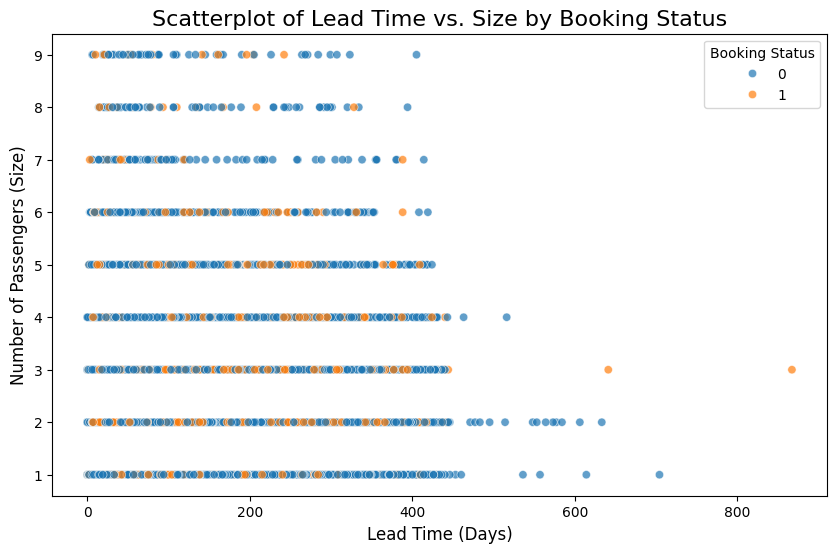

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatterplot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=result_df,
    x='lead_time',  # Independent variable
    y='size',       # Independent variable
    hue='booking',  # Dependent variable (classification target)
    palette='tab10',  # Color palette for classes
    alpha=0.7       # Transparency for overlapping points
)

# Add labels and title
plt.title('Scatterplot of Lead Time vs. Size by Booking Status', fontsize=16)
plt.xlabel('Lead Time (Days)', fontsize=12)
plt.ylabel('Number of Passengers (Size)', fontsize=12)
plt.legend(title='Booking Status', loc='upper right')

# Show the plot
plt.show()


****PRELIMINARY ANALYSIS**** <br>
Based on the scatterplot, group sizes between 1 and 5 people tend to book their flights within 450 days of departure. Smaller groups, particularly those with 1 or 2 people, are slightly more likely to book flights more than 450 days in advance compared to groups of size 3, 4, or 5. However, the majority of bookings for groups of 1 or 2 still occur within the 450-day window.

Larger groups, consisting of 6 to 9 people, are less common and generally book flights within 350 days of departure.

The scatterplot suggests that group size may be a strong indicator of whether a booking is completed. Groups of size 2 to 6 are more likely to complete their bookings compared to groups of size 1, 7, 8, or 9. This trend is intuitive, as individuals traveling alone may browse flights without committing to a booking. In contrast, groups are more likely to commit because they are coordinating a trip together. Additionally, the lower frequency of groups with 7, 8, or 9 members likely contributes to the smaller number of completed bookings observed for these group sizes.

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [6]:
# Step 1: Prepare your data
# Example: Create a synthetic classification dataset
# Replace this with your actual dataset if you have it (e.g., `result_df` or another DataFrame)
#X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)


X = result_df[['lead_time', 'size']]  # Features
y = result_df['booking']  # Target

# Step 2: Initialize models with parameters
logreg = LogisticRegression(max_iter=100, random_state=42)
dtree = DecisionTreeClassifier(max_depth=10, random_state=42)
gnb = GaussianNB()

# Step 3: Perform cross-validation for each classifier

# Logistic Regression: Cross-validation score
logreg_cv = cross_val_score(logreg, X, y, cv=10)
print(f'Logistic Regression CV Mean Accuracy: {np.mean(logreg_cv):.4f}')

# Decision Tree Classifier: Cross-validation score
dtree_cv = cross_val_score(dtree, X, y, cv=10)
print(f'Decision Tree CV Mean Accuracy: {np.mean(dtree_cv):.4f}')

# Gaussian Naive Bayes: Cross-validation score
gnb_cv = cross_val_score(gnb, X, y, cv=10)
print(f'Gaussian Naive Bayes CV Mean Accuracy: {np.mean(gnb_cv):.4f}')


Logistic Regression CV Mean Accuracy: 0.8441
Decision Tree CV Mean Accuracy: 0.8429
Gaussian Naive Bayes CV Mean Accuracy: 0.8415


****BEST METHOD ANALYSIS**** <br>
Based on the 10-fold cross validation score, it appears that Logistic Regression with 100 iterations outperforms our Decision Tree and Gaussian Naive Bayes models with an CV mean accuracy of 84.41%.

Optimal Tree Depth: 1


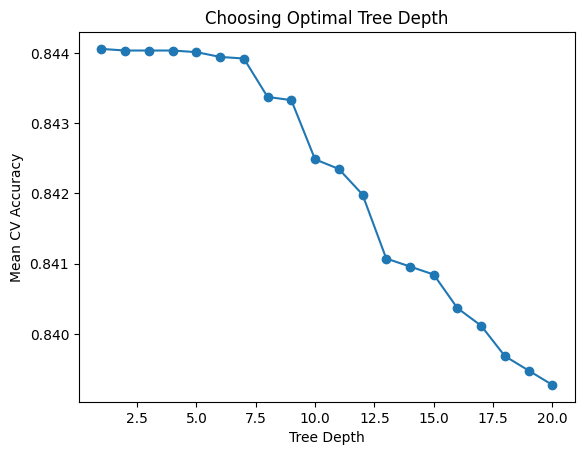

In [7]:
depth_range = range(1, 21)

# Store cross-validation scores
mean_scores = []

for depth in depth_range:
    # Create decision tree with specified depth
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    
    # Store mean score
    mean_scores.append(np.mean(scores))

# Find the optimal depth
optimal_depth = depth_range[np.argmax(mean_scores)]
print(f"Optimal Tree Depth: {optimal_depth}")

# Plot results (optional)
import matplotlib.pyplot as plt
plt.plot(depth_range, mean_scores, marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Mean CV Accuracy')
plt.title('Choosing Optimal Tree Depth')
plt.show()

****OPTIMAL TREE DEPTH****<br>
After performing 5-fold cross validation to determine the optimal tree depth, it appears that a depth of 1 has the highest CV mean accuracy score of 84.4%. Once we increase the depth to 5, there is a negative linear relationship between tree deptch and CV mean accuracy.

In [9]:
import statsmodels.api as sm

# Add a constant for the intercept term
X = sm.add_constant(X)

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.432165
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                booking   No. Observations:                43901
Model:                          Logit   Df Residuals:                    43898
Method:                           MLE   Df Model:                            2
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                0.001650
Time:                        12:32:49   Log-Likelihood:                -18972.
converged:                       True   LL-Null:                       -19004.
Covariance Type:            nonrobust   LLR p-value:                 2.427e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7249      0.025    -68.408      0.000      -1.774      -1.675
lead_time     -0.0010      0.

****INTERPRETATION OF LOGIT RESULTS****<br>
Given the limited information we have, it is unclear whether or not this is the best model for our dataset. Each of the independent variables have a low p-score, indicating that they are all statistically significant predictors of whether or not a group completes their booking. However, the Psuedo R-squared value is low indicating that this model does not explain much of the variability in the dataset. We would not recommend this model to predict bookings in the future because we feel like another model may predict better. 

In [14]:
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import bias_variance_decomp


# Split the dataset (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

# Train Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=1, random_state=42)
tree_clf.fit(X_train, y_train)

# Bias-Variance Decomposition
avg_expected_loss, avg_bias, avg_variance = bias_variance_decomp(
    tree_clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=42
)

# Results
print(f"Average Expected Loss (MSE): {avg_expected_loss:.4f}")
print(f"Average Bias: {avg_bias:.4f}")
print(f"Average Variance: {avg_variance:.4f}")

Average Expected Loss (MSE): 0.1559
Average Bias: 0.1559
Average Variance: 0.0000


****INTERPRETATION**** <br>
Looking at the MSE, our model misclassifies about 15.59% of the data. It has a high bias of 15.59% indicating that our decision tree may be too simple and underfitting the data. It has an extremeley low variance indicating that is generalizing well to unseen data. We want to balance bias and variance to make sure we are not over nor underfitting the data. Perhaps using a slightly more complex tree with a greater depth would help us decrease our bias while still maintaining a low variance.  

In [15]:
# Split the dataset (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False, stratify=None
)
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

# Train Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=1,random_state=42)
tree_clf.fit(X_train, y_train)

# Bias-Variance Decomposition
avg_expected_loss, avg_bias, avg_variance = bias_variance_decomp(
    tree_clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=42
)

# Results
print(f"Average Expected Loss (MSE): {avg_expected_loss:.4f}")
print(f"Average Bias: {avg_bias:.4f}")
print(f"Average Variance: {avg_variance:.4f}")

Average Expected Loss (MSE): 0.2072
Average Bias: 0.2072
Average Variance: 0.0000


****ANALYSIS****<br>
Not shuffling nor stratifying the data does make a difference in the performance of the model. It increases our misclassification rate to 20.72% while increasing our bias as well. Variance stays the same. 

In [16]:
from sklearn.ensemble import BaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)

X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

# Iterate over different values of n_estimators
for n_estimators in [100]:
    # Initialize Bagging Classifier with DecisionTreeClassifier as the base estimator
    bagging_clf = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=n_estimators,
        random_state=42,
        n_jobs=-1
    )
    bagging_clf.fit(X_train, y_train)

    # Bias-Variance Decomposition
    avg_expected_loss, avg_bias, avg_variance = bias_variance_decomp(
        bagging_clf, X_train, y_train, X_test, y_test, loss='0-1_loss', random_seed=42
    )

    # Results
    print(f"Results with {n_estimators} estimators:")
    print(f"Average Expected Loss (MSE): {avg_expected_loss:.4f}")
    print(f"Average Bias: {avg_bias:.4f}")
    print(f"Average Variance: {avg_variance:.4f}")
    print("-" * 50)

Results with 100 estimators:
Average Expected Loss (MSE): 0.1697
Average Bias: 0.1616
Average Variance: 0.0174
--------------------------------------------------


****SUMMARY****<br>
It took too long for our computer to run this on more than 100 estimators. With 100 estimators, we can see that our misclassification rate was 16.97%. Our bias was slighly lower at 16.16% and our variance was slightly higher compared to the singular decision tree at 1.74%. The purpose of bagging is to avoid overfitting because it uses a majority vote for the final prediction rather than one singular model. 

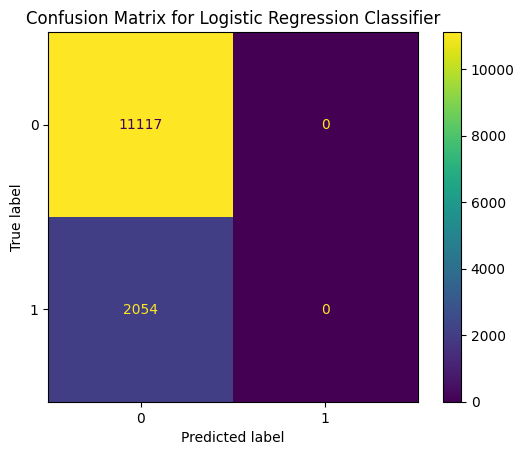

Confusion Matrix:
[[11117     0]
 [ 2054     0]]


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Split data into training (70%) and test (30%) sets with shuffle=True and stratify=y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)

# Train a logistic regression model
logreg = LogisticRegression(max_iter=100, random_state=42)
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)
class_labels = [0, 1]

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')

# Show the plot
plt.title("Confusion Matrix for Logistic Regression Classifier")
plt.show()

# Print the confusion matrix for further analysis
print("Confusion Matrix:")
print(cm)

****ANALYSIS****<br>
From our confusion matrix, we can observe that the logistic regression model does not perform well in predicting the class of the booking status. The dataset is imbalanced, with the majority class being "booking incomplete." Due to this imbalance, the model tends to predict the majority class (booking incomplete) for almost all cases. This results in a high accuracy, but it is misleading, as the model is essentially "lazy" in making predictions.

While the model achieves a high accuracy by always predicting the majority class, this approach is not helpful in practice. Our goal is to accurately predict when a booking is complete, not simply predict the dominant class. In other words, a model that always predicts the majority class does not provide any useful insights into the minority class which is what we are interested in.